In [5]:
import os
from tqdm import tqdm 
import pandas as pd
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

### Evaluate RAG

#### read dataset

In [6]:
# Read data into dataframe 
data_file_path = os.path.join('..','app','data', 'data.csv')
df = pd.read_csv(data_file_path).dropna() 

# Convert dataframe to list of dictionaries
data_dict = df.to_dict(orient="records")

In [60]:
data_dict[100]

{'id': '30a06ee3',
 'question': "How can 'adaptive hyperparameter tuning' techniques like Hyperband and Successive Halving improve upon traditional methods?",
 'answer': 'Adaptive hyperparameter tuning techniques like Hyperband and Successive Halving improve upon traditional methods by efficiently allocating computational resources and dynamically pruning less promising configurations. Hyperband combines random search with early stopping to allocate more resources to promising hyperparameter configurations while discarding poorly performing ones. Successive Halving similarly starts with many configurations with limited resources and progressively allocates more resources to the top-performing ones. These methods reduce the overall computational cost and improve the likelihood of finding optimal hyperparameters by focusing resources on the most promising areas.',
 'topic': 'Model Tuning'}

In [56]:
doc_idx = {d['id']: d for d in data_dict}

#### Get ground truth data

In [7]:
ground_truth_file_path = os.path.join('..','app','data', 'ground_truth.csv')
df_ground_truth = pd.read_csv(ground_truth_file_path, header = 0, usecols=[0, 1])

In [9]:
ground_truth = df_ground_truth.to_dict(orient='records')

In [10]:
print(len(ground_truth), ground_truth[0])

1735 {'question': 'When is it appropriate to use classification rather than regression?', 'document_id': '34a96b07'}


#### create vector embeddings 

In [28]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
embedding_size = 384 
model = SentenceTransformer(model_name)
index_name = 'python-qa-index'
es = Elasticsearch("http://localhost:9200")

In [16]:
index_settings={
    "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
        "question": {"type": "text"},
        "answer": {"type": "text"},
        "topic": {"type": "keyword"},
        "id": {"type": "keyword"},
        "answer_vector": {"type": "dense_vector", "dims": embedding_size, "index": True, "similarity": "cosine"},
        "question_vector": {"type": "dense_vector", "dims": embedding_size, "index": True, "similarity": "cosine"},
        "question_answer_vector": {"type": "dense_vector", "dims": embedding_size, "index": True, "similarity": "cosine"},
        }
    }
}

# Create Index and delete if it already exists
es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body = index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'python-qa-index'})

Embedding the answer and query vector

In [17]:
vector_data_dict = []
for i in tqdm(data_dict):
    question_answer = i['question'] + ' ' + i['answer']
    i['answer_vector'] = model.encode(i['answer'])
    i['question_vector'] = model.encode(i['question'])
    i['question_answer_vector'] = model.encode(question_answer)
    vector_data_dict.append(i)

100%|██████████| 638/638 [02:29<00:00,  4.28it/s]


#### Creating index on data

In [18]:
# Add Data to Index using index()
print('\n\n[[DEBUG] Adding data to index...')
for i in tqdm(vector_data_dict):
    row = i
    es.index(index=index_name, document=row)



[[DEBUG] Adding data to index...


100%|██████████| 638/638 [00:44<00:00, 14.36it/s]


In [22]:
print(es.info())

{'name': '9bdc783e34e8', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'B5U4KU4BQ4SohVLf9NsLQA', 'version': {'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [23]:
def elastic_search_knn(field, vector):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
    }
    search_query = {
        "knn": knn,
        "_source": ["answer", "question", "topic", "id"]
    }
    es_results = es.search(
        index=index_name, 
        body=search_query
    )
    result_docs = []
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

#### RAG Flow

In [29]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
llm_model_name = 'google/flan-t5-small'
tokenizer = T5Tokenizer.from_pretrained(llm_model_name)
llm_model = T5ForConditionalGeneration.from_pretrained(llm_model_name)

In [30]:
def question_answer_vector_knn(q):
    question = q['question'] 
    v_q = model.encode(question)

    return elastic_search_knn('question_answer_vector', v_q)

In [40]:
def generate_prompt(query, response):
    prompt_template = """
        You're a data science expert and assistant.
        Provide concise and complete answers to the questions based on the context given below.
        QUESTION: {question}

        CONTEXT: 
        {response}
        """.strip()

    prompt = prompt_template.format(question=query, response=response)
    return prompt

In [41]:
def llm(prompt):
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        max_length=512, 
        truncation=True, 
        padding='max_length'
    )
    # Generate Response
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=1024,
        min_length=100,
        no_repeat_ngram_size=3,
        do_sample=True, 
        num_beams=4,        
        early_stopping = True # Stop once all beams are finished  
    )
    
    llm_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return llm_response

In [42]:
def rag_pipeline(query: dict) -> str:
    search_results =question_answer_vector_knn(query)
    prompt = generate_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [43]:
ground_truth[10]

{'question': 'How can you avoid overfitting when building a predictive model?',
 'document_id': '10e5ca34'}

In [44]:
rag_pipeline(ground_truth[10])

'Cross-Validation: Use techniques like k-fold cross-validation to ensure that your model generalizes well across different subsets of the data. Follow the guidelines on how to avoid overfitting when building a predictive model, including the following strategies: 1) Regularization: Apply L1 or L2 regularization to penalize excessive model parameters and prevent the model from fitting noise. 2) Dropout: Implement dropout layers during training to randomly omit neurons and reduce dependency on specific features.'

In [61]:
doc_idx['10e5ca34']['answer']

'To avoid overfitting, you can: 1) Simplify the model by reducing its complexity or the number of features, 2) Use cross-validation techniques like k-fold cross-validation to ensure the model performs well on unseen data, and 3) Apply regularization techniques such as LASSO to penalize excessive model parameters and reduce overfitting.'

In [68]:
answers ={}

#### Generate LLM answers 

In [76]:
for i, rec in enumerate(tqdm(ground_truth[26:])):
    if i in answers:
        continue

    answer_llm = rag_pipeline(rec)
    doc_id = rec['document_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer'] 
    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document_id': doc_id,
        'question': rec['question']
    }

100%|██████████| 1709/1709 [4:49:55<00:00, 10.18s/it]    


In [85]:
answers[3]

{'answer_llm': "Accuracy measures the proportion of correct predictions, while the F1 score balances precision and recall. ROC-AUC: The area under the receiver operating characteristic curve, which measures the model's ability to distinguish between classes. The confusion matrix provides a detailed breakdown of true positives, true negatives, false positives and false negatives. 'question': 'What evaluation approaches would you work to gauge the effectiveness of a machine learning model?'",
 'answer_orig': 'Use classification when you need to categorize data into discrete classes or labels, such as predicting if an email is spam or not. Use regression when predicting continuous values or quantities, such as forecasting sales or temperatures. Classification deals with categorical outcomes, while regression handles numerical predictions.',
 'document_id': '34a96b07',
 'question': 'What are the key indicators that suggest using classification instead of regression?'}

In [77]:
# Save data to file
answers_df = pd.DataFrame.from_dict(answers)
answers_df.to_csv('rag_eval.csv', index=False)

In [81]:
answers_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708
answer_llm,linear regression and polynomial regression de...,Choosing between linear regression and polynom...,Neural Network and a Decision Tree for a regre...,Accuracy measures the proportion of correct pr...,Linear regression models are simpler and easie...,Stacking is another method that combines multi...,Using Stacking**: Training a meta-model to com...,"Stacking method, which sequentially trains mod...",['Questition': 'Name an example where ensemble...,"'What is ensemble learning, and how can it be ...",...,Answer': Managing versioning and updates invol...,answers: Managing versioning and updates invol...,Managing versioning and updates involves imple...,answer: Managing versioning and updates involv...,answers: Managing versioning and updates invol...,transfer learning leverages knowledge from a p...,Pre-trained LLMs are useful when there is limi...,transfer learning leverages knowledge from a p...,"multi-task learning scenarios, transfer learni...",transfer learning leverages knowledge from a p...
answer_orig,Use classification when you need to categorize...,Use classification when you need to categorize...,Use classification when you need to categorize...,Use classification when you need to categorize...,Use classification when you need to categorize...,"Ensemble techniques, like bagging and boosting...","Ensemble techniques, like bagging and boosting...","Ensemble techniques, like bagging and boosting...","Ensemble techniques, like bagging and boosting...","Ensemble techniques, like bagging and boosting...",...,Managing versioning and updates involves imple...,Managing versioning and updates involves imple...,Managing versioning and updates involves imple...,Managing versioning and updates involves imple...,Managing versioning and updates involves imple...,Transfer learning involves pre-training a mode...,Transfer learning involves pre-training a mode...,Transfer learning involves pre-training a mode...,Transfer learning involves pre-training a mode...,Transfer learning involves pre-training a mode...
document_id,34a96b07,34a96b07,34a96b07,34a96b07,34a96b07,2075cd3f,2075cd3f,2075cd3f,2075cd3f,2075cd3f,...,c6b888be,c6b888be,c6b888be,c6b888be,c6b888be,137220a3,137220a3,137220a3,137220a3,137220a3
question,When is it appropriate to use classification r...,In which scenarios would you prefer classifica...,Can you explain a situation where classificati...,What are the key indicators that suggest using...,When should you opt for classification as oppo...,What is a situation where ensemble methods wou...,Can you give an example of how ensemble techni...,When might ensemble methods be particularly be...,What are some scenarios where using an ensembl...,How can ensemble techniques enhance the result...,...,How is versioning managed for LLMs?,What practices are used for updating and track...,How do you ensure proper version control for d...,What are effective techniques for managing upd...,How is model versioning handled in the context...,How does transfer learning apply to large lang...,What is the relevance of transfer learning for...,How can transfer learning improve LLMs?,What role does transfer learning play in optim...,How is transfer learning used to enhance large...


#### Calculate similarity

In [86]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [87]:
similarity = []

for record in tqdm(answers.values()):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1709/1709 [04:12<00:00,  6.77it/s]


## RAG Performance

C:\Users\h4has\AppData\Local\Temp\ipykernel_45088\44070947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(similarity)


<Axes: ylabel='Density'>

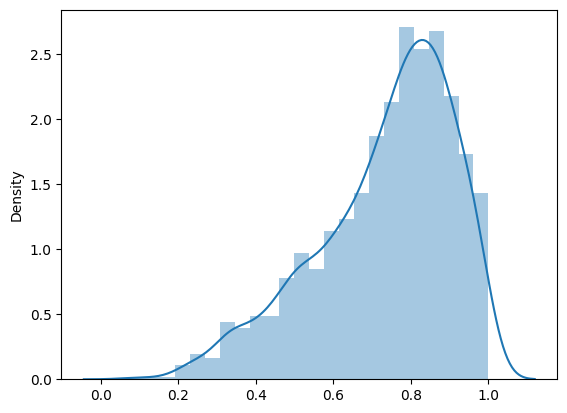

In [92]:
import seaborn as sns
sns.distplot(similarity)